In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:58:46) 
[Clang 11.1.0 ]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


In [2]:
fname = '../figures/'

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load the Data

In [7]:
df = pd.read_csv("../data/fifa19_dataset.csv", index_col = 0)
df = df.iloc[: , 1:]
df.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Gather info on the Dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 18206
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Photo                     18207 non-null  object 
 3   Nationality               18207 non-null  object 
 4   Flag                      18207 non-null  object 
 5   Overall                   18207 non-null  int64  
 6   Potential                 18207 non-null  int64  
 7   Club                      17966 non-null  object 
 8   Club Logo                 18207 non-null  object 
 9   Value                     18207 non-null  object 
 10  Wage                      18207 non-null  object 
 11  Special                   18207 non-null  int64  
 12  Preferred Foot            18159 non-null  object 
 13  International Reputation  18159 non-null  float64
 14  Weak F

## Determine the number of rows and columns

In [9]:
rows = df.shape[0]
columns = df.shape[1]

print("Number of rows: ", rows)
print("Number of columns: ", columns)

Number of rows:  18207
Number of columns:  87


## Determine the data types for each attribute

In [10]:
dtype_Dict = df.dtypes.to_dict()

for column_name, d_type in dtype_Dict.items(): 
    print(column_name,": ", d_type)

Name :  object
Age :  int64
Photo :  object
Nationality :  object
Flag :  object
Overall :  int64
Potential :  int64
Club :  object
Club Logo :  object
Value :  object
Wage :  object
Special :  int64
Preferred Foot :  object
International Reputation :  float64
Weak Foot :  float64
Skill Moves :  float64
Work Rate :  object
Body Type :  object
Real Face :  object
Position :  object
Jersey Number :  float64
Joined :  object
Loaned From :  object
Contract Valid Until :  object
Height :  object
Weight :  object
LS :  object
ST :  object
RS :  object
LW :  object
LF :  object
CF :  object
RF :  object
RW :  object
LAM :  object
CAM :  object
RAM :  object
LM :  object
LCM :  object
CM :  object
RCM :  object
RM :  object
LWB :  object
LDM :  object
CDM :  object
RDM :  object
RWB :  object
LB :  object
LCB :  object
CB :  object
RCB :  object
RB :  object
Crossing :  float64
Finishing :  float64
HeadingAccuracy :  float64
ShortPassing :  float64
Volleys :  float64
Dribbling :  float64
Curve

## Determine the number of numerical and categorical features

In [11]:
numerical_values = ["int64", "Float64"]
categorical_values = ["object"]
count_numerical_values = len(df.select_dtypes(include = numerical_values).columns)
count_categorical_values = len(df.select_dtypes(include = categorical_values).columns)

print("Number of Numerical Features: ", count_numerical_values)
print("Number of Categorical Features: ", count_categorical_values)

Number of Numerical Features:  42
Number of Categorical Features:  45


## Describe the Dataframe

In [12]:
df.describe()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,45.550911,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,19.525820,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,30.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,49.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,95.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


## Describe the Target Variable

In [13]:
df["Position"].describe()

count     18147
unique       27
top          ST
freq       2152
Name: Position, dtype: object

## Determine if there are empty values

In [14]:
df.isna().any().any()

True

## How many empty values are there

In [15]:
df.isna().sum().sum()

76984

## Determine the sum of missing values for each column 

In [16]:
df.isnull().sum()

Name                 0
Age                  0
Photo                0
Nationality          0
Flag                 0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 87, dtype: int64

## Percentage of empty values for each attribute

In [17]:
df.isna().sum()/(len(df))*100

Name              0.000000
Age               0.000000
Photo             0.000000
Nationality       0.000000
Flag              0.000000
                    ...   
GKHandling        0.263635
GKKicking         0.263635
GKPositioning     0.263635
GKReflexes        0.263635
Release Clause    8.590103
Length: 87, dtype: float64

## Display columns with empty values

In [18]:
df.loc[:, df.isnull().any()].columns

Index(['Club', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')

## Fill in the missing values with NaN

In [19]:
df.fillna(np.nan)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,https://cdn.sofifa.org/teams/2/light/121.png,€60K,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,https://cdn.sofifa.org/teams/2/light/703.png,€60K,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,https://cdn.sofifa.org/teams/2/light/1944.png,€60K,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,https://cdn.sofifa.org/teams/2/light/15048.png,€60K,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


<AxesSubplot:>

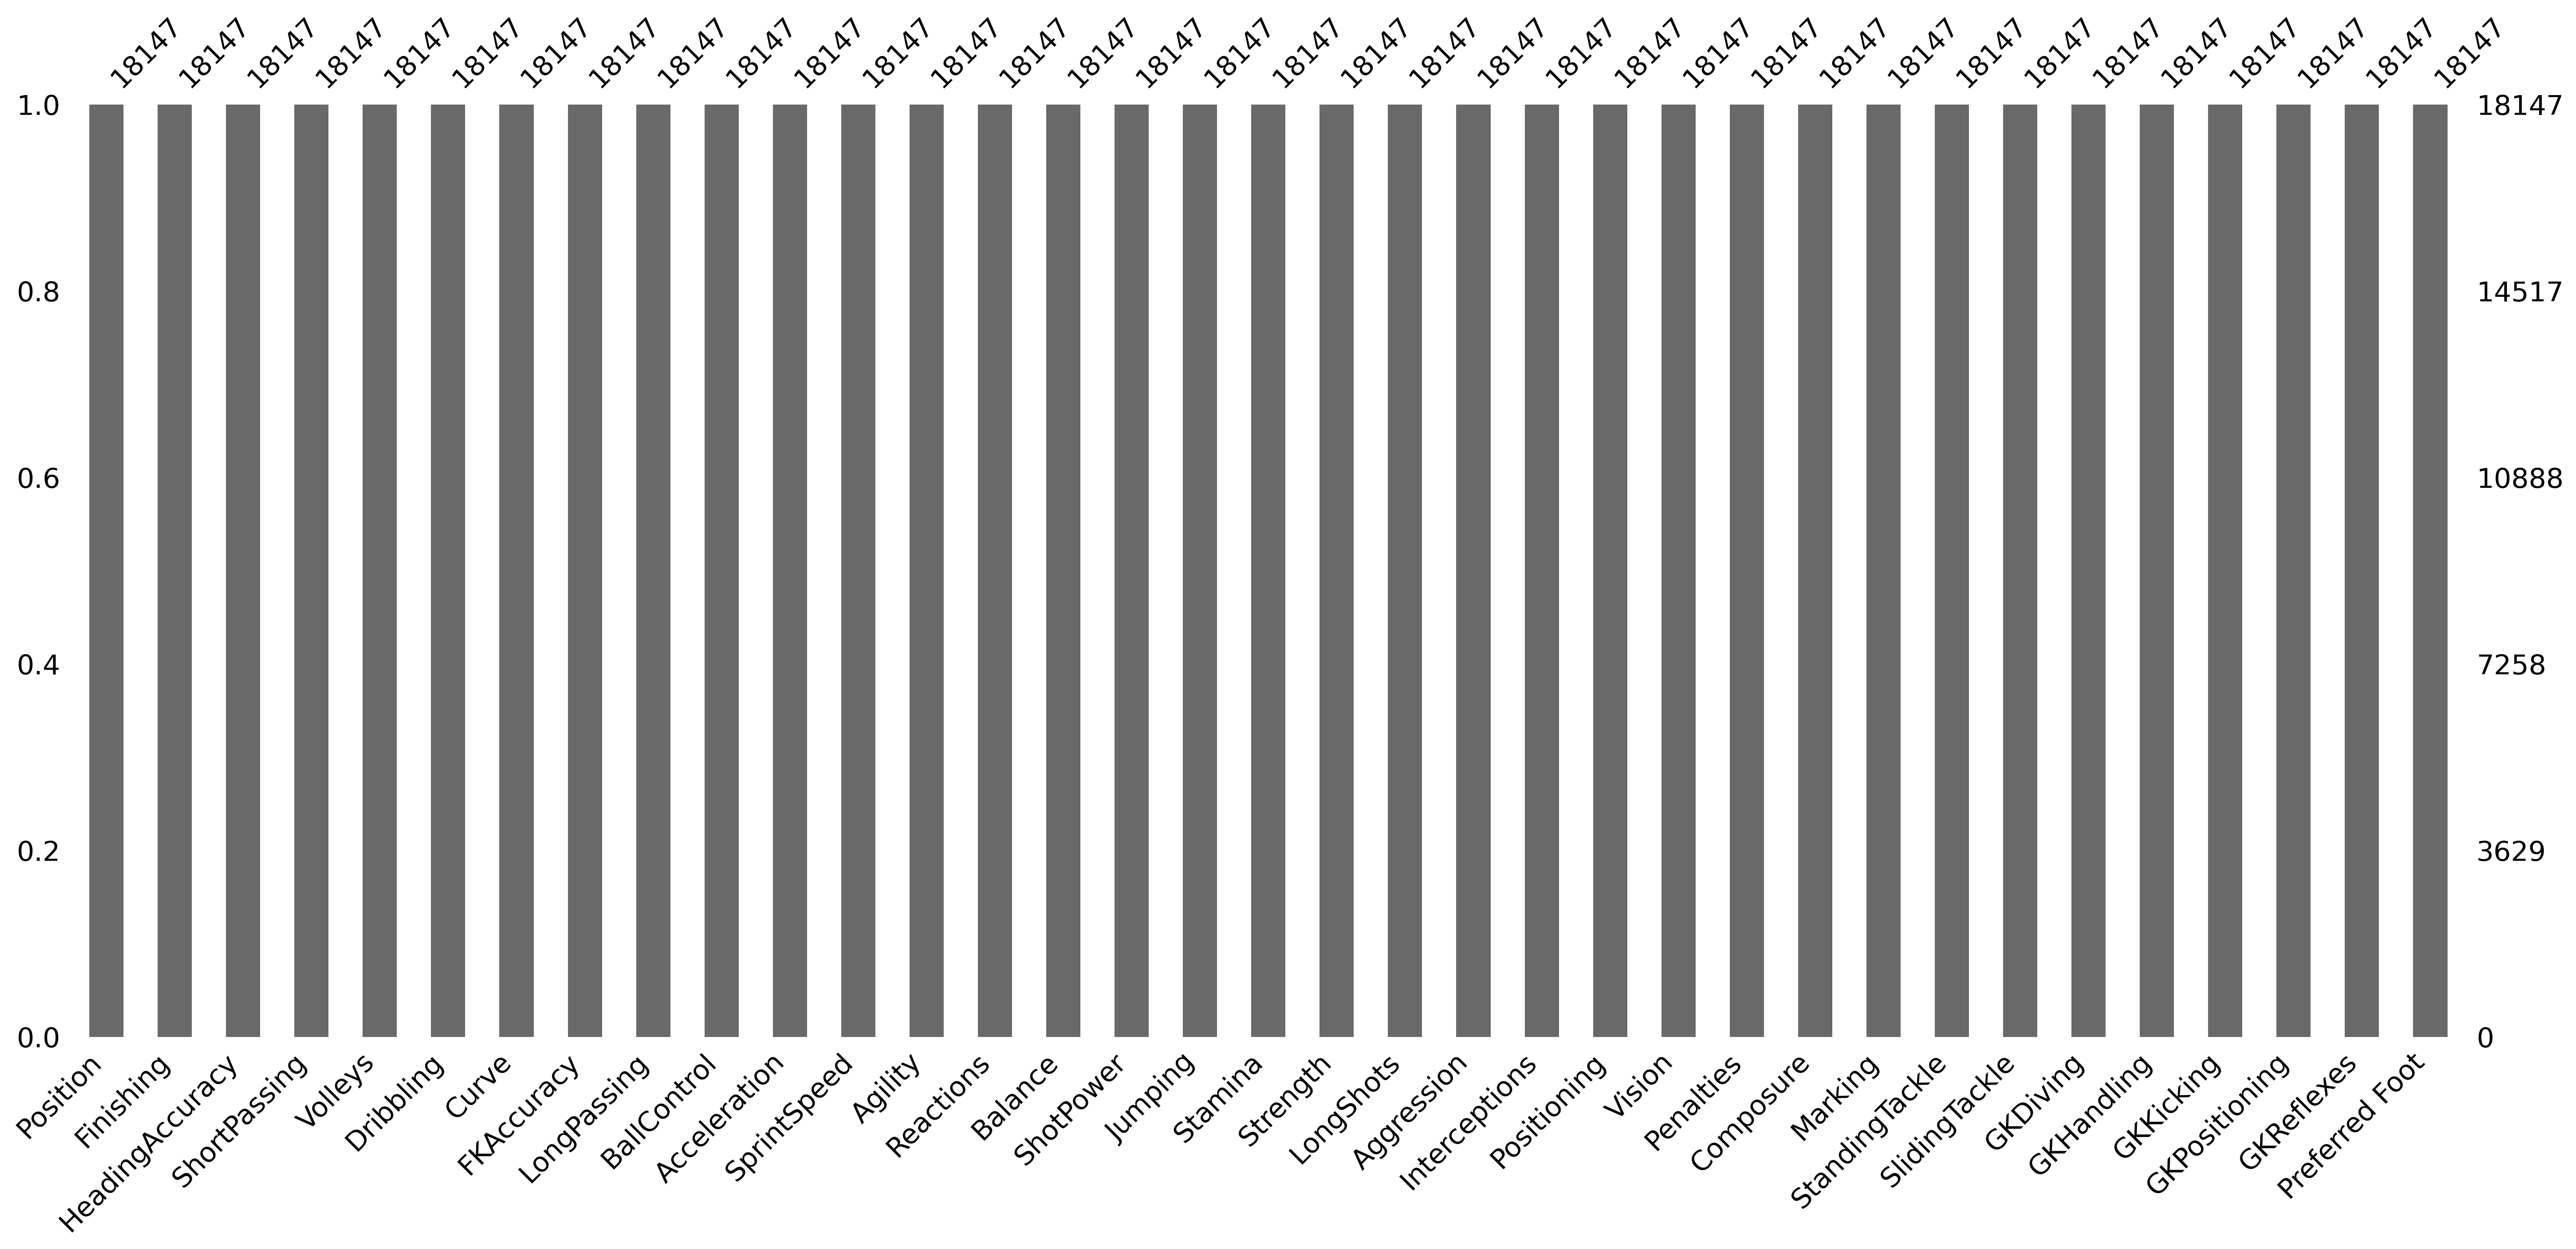

In [49]:
msno.bar(df)

<AxesSubplot:>

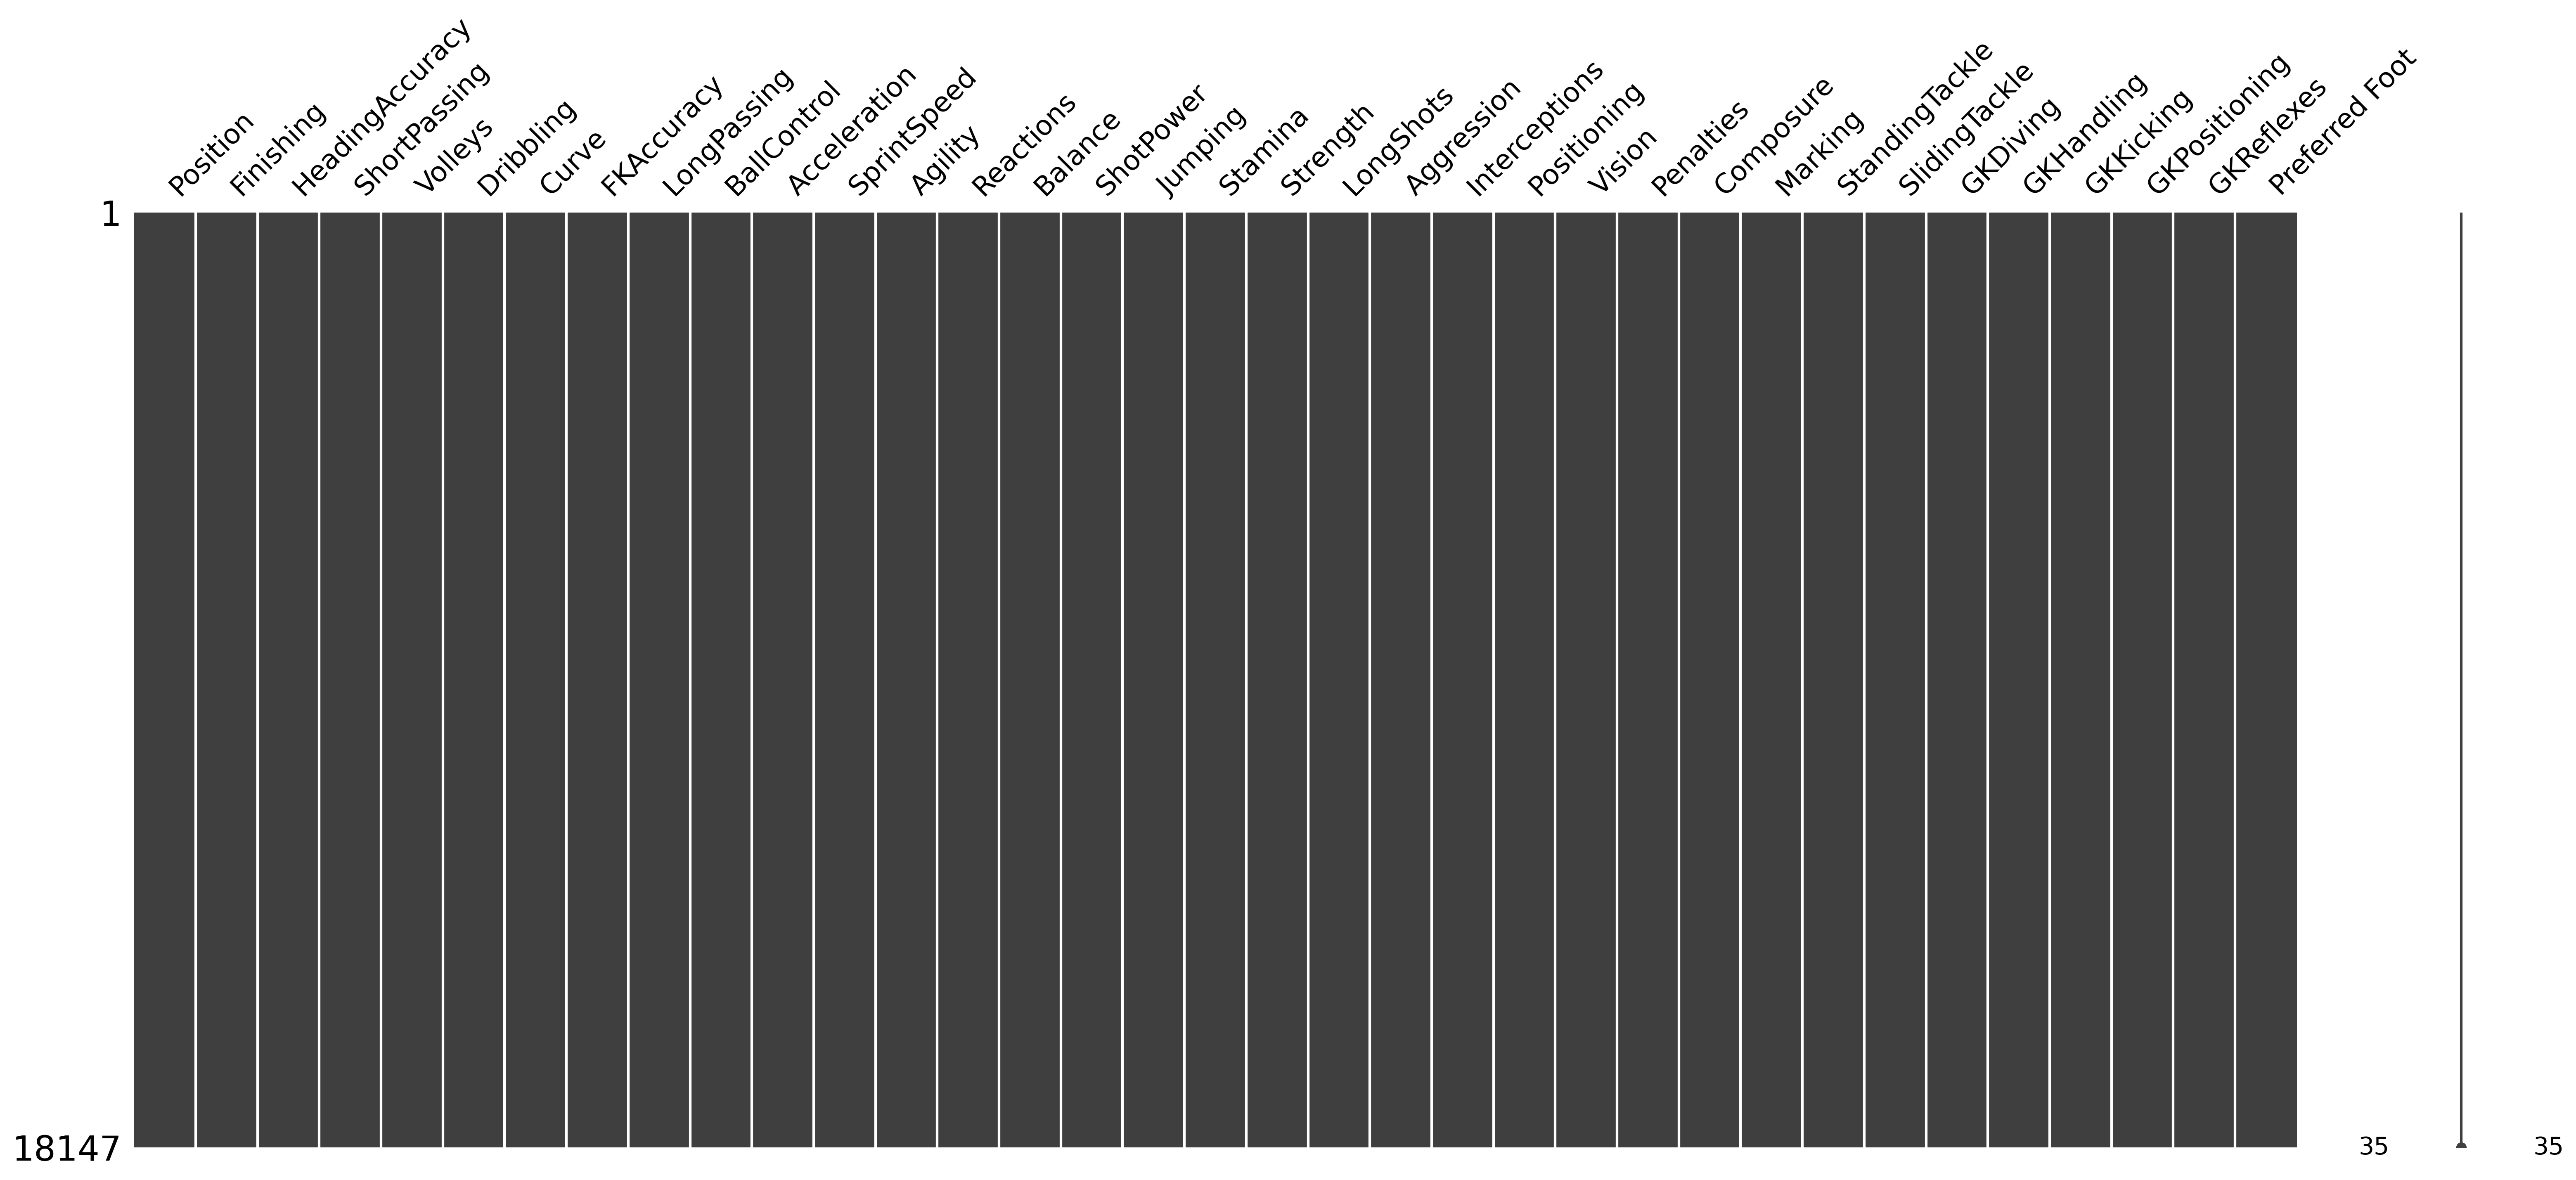

In [50]:
msno.matrix(df)

<AxesSubplot:>

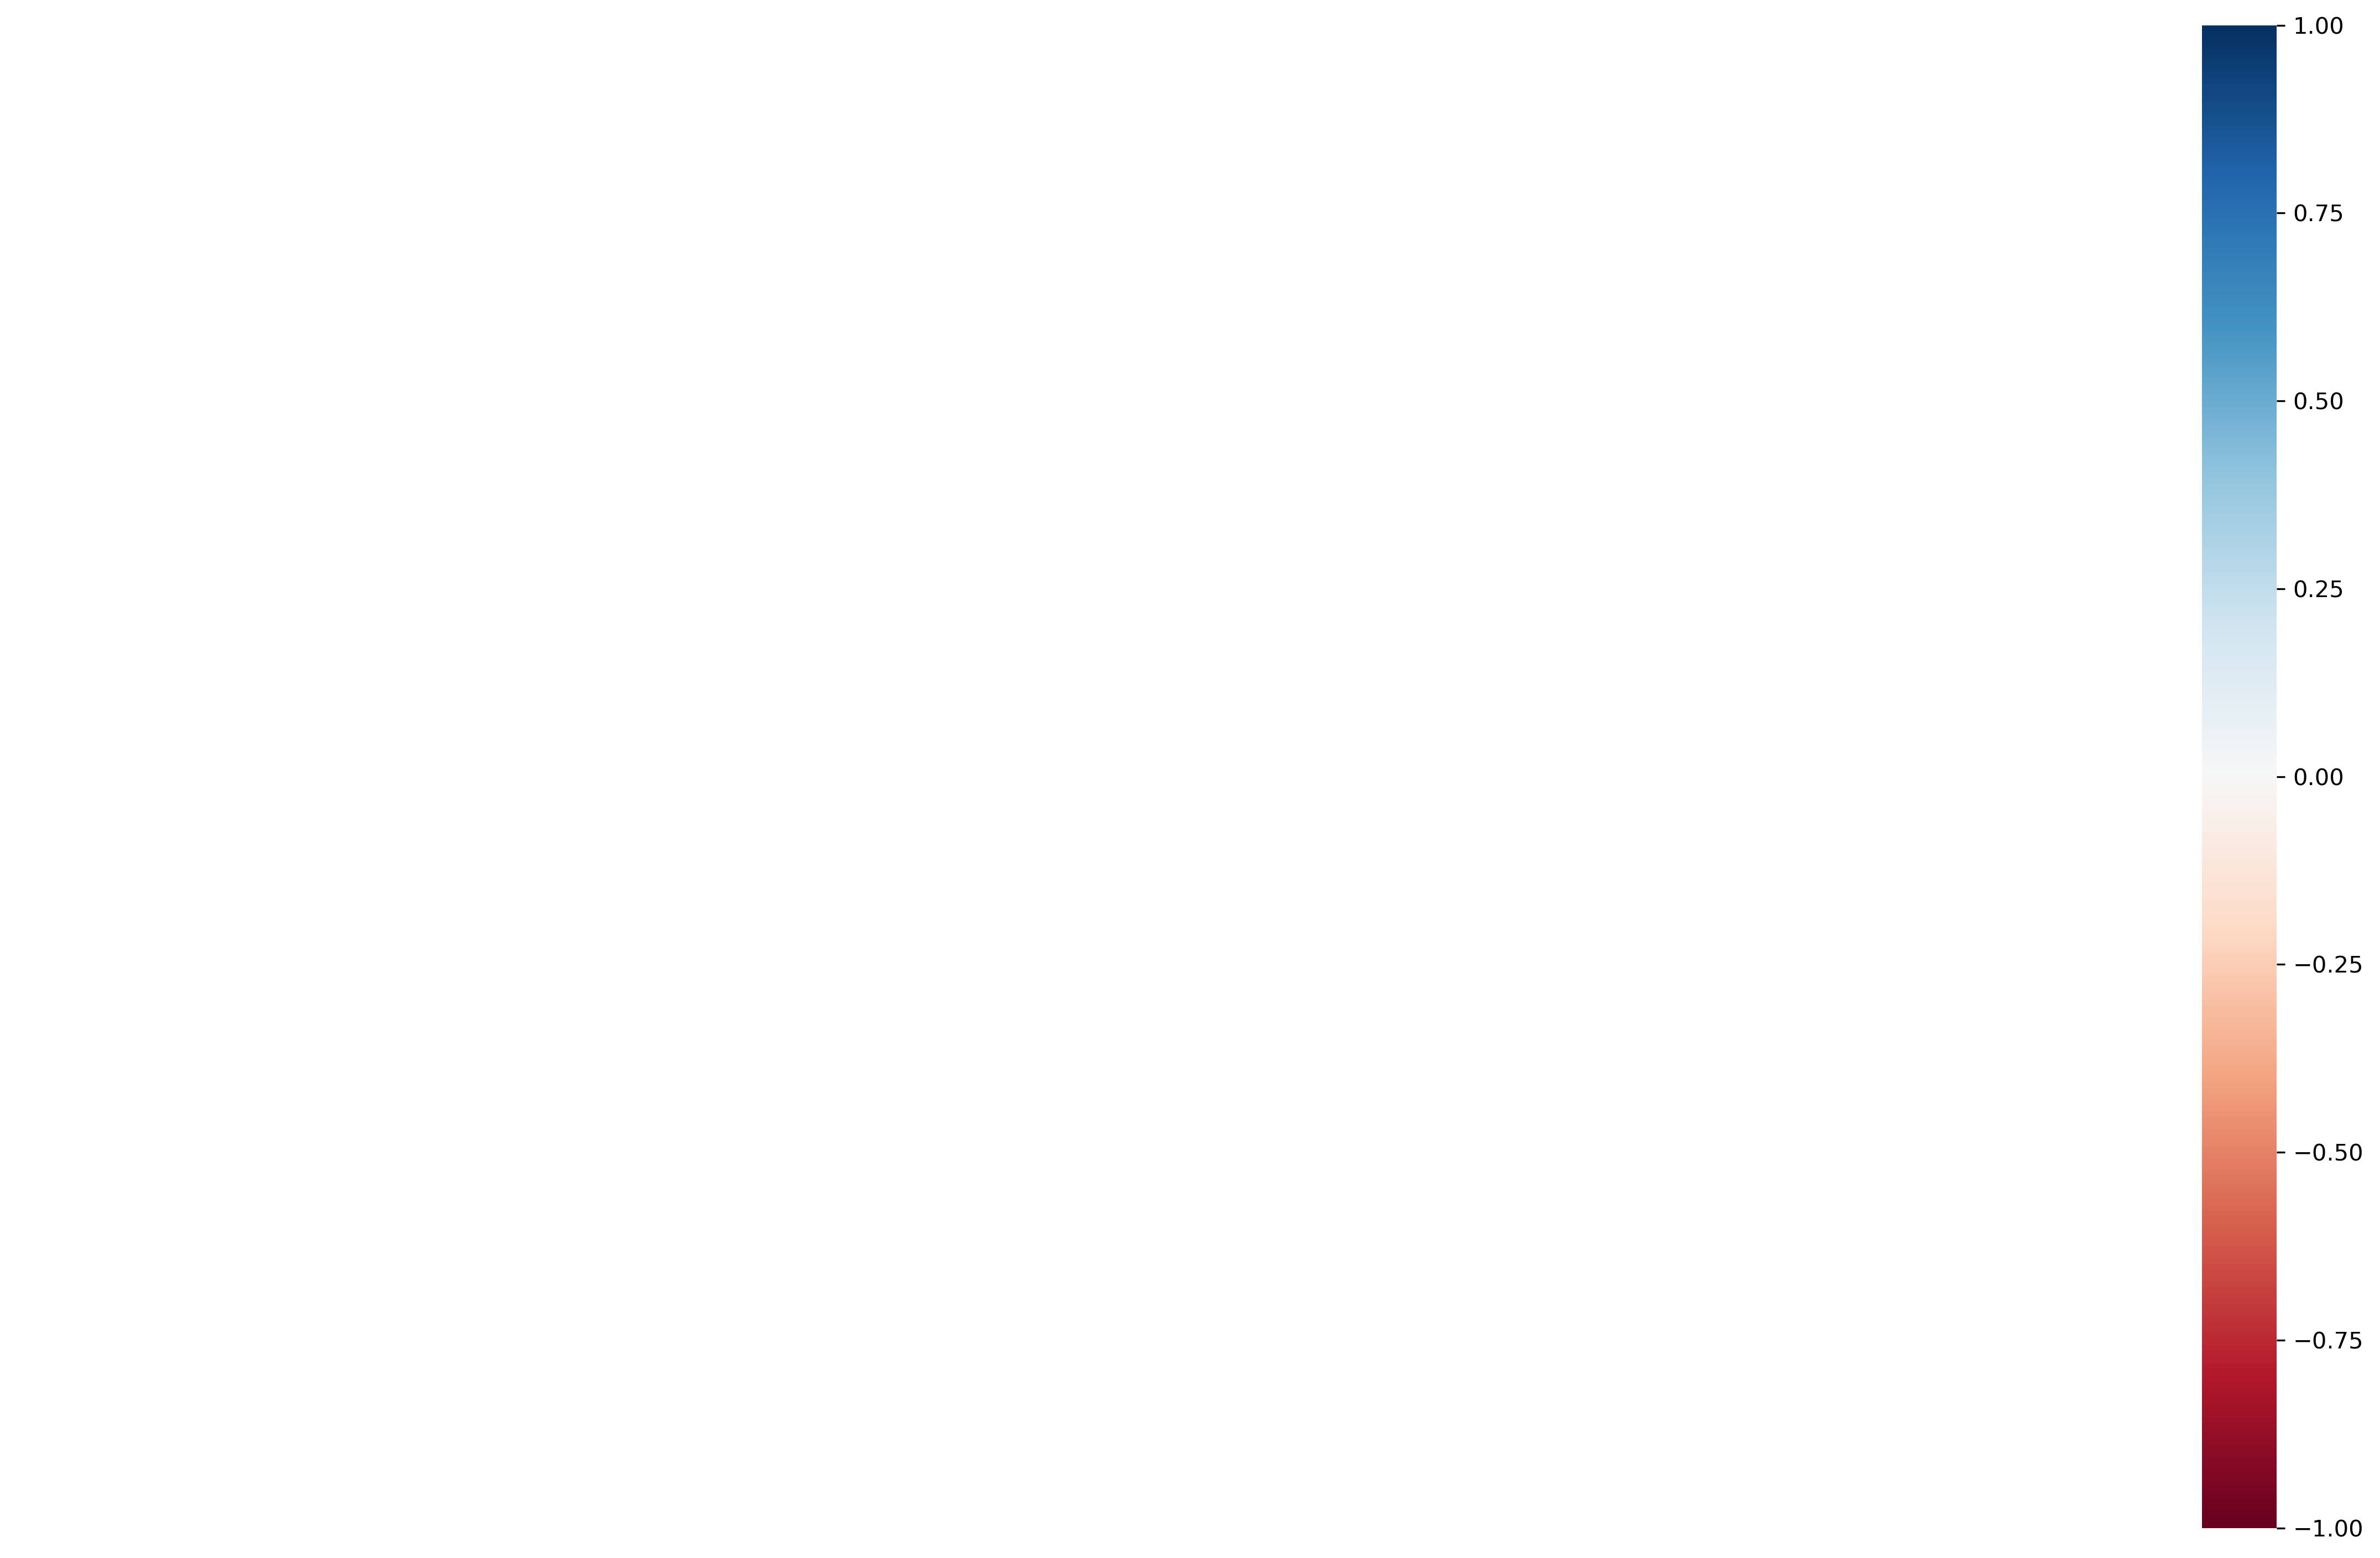

In [48]:
msno.heatmap(df)

## Visualize the Target Variable

In [23]:
df["Position"].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

In [24]:
df["Position"].describe()

count     18147
unique       27
top          ST
freq       2152
Name: Position, dtype: object

In [25]:
df_positions_empty = df[df["RAM"].isna()]
df_positions_empty.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,J. Oblak,25,https://cdn.sofifa.org/players/4/19/200389.png,Slovenia,https://cdn.sofifa.org/flags/44.png,90,93,Atlético Madrid,https://cdn.sofifa.org/teams/2/light/240.png,€68M,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,M. ter Stegen,26,https://cdn.sofifa.org/players/4/19/192448.png,Germany,https://cdn.sofifa.org/flags/21.png,89,92,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€58M,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,T. Courtois,26,https://cdn.sofifa.org/players/4/19/192119.png,Belgium,https://cdn.sofifa.org/flags/7.png,89,90,Real Madrid,https://cdn.sofifa.org/teams/2/light/243.png,€53.5M,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,M. Neuer,32,https://cdn.sofifa.org/players/4/19/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,89,89,FC Bayern München,https://cdn.sofifa.org/teams/2/light/21.png,€38M,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M


In [26]:
df_positions_empty["Position"].value_counts()

GK    2025
Name: Position, dtype: int64

<AxesSubplot:title={'center':'Frequency of Each Position in the Dataset'}, xlabel='Position', ylabel='Frequency of Position'>

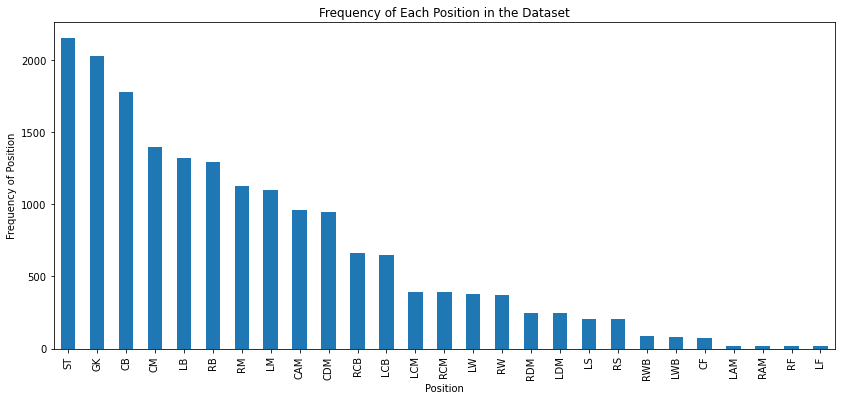

In [27]:
df_position_count = df["Position"].value_counts()
df_position_count.plot(kind = "bar", title = "Frequency of Each Position in the Dataset", xlabel = "Position", ylabel = "Frequency of Position", figsize=[14, 6])

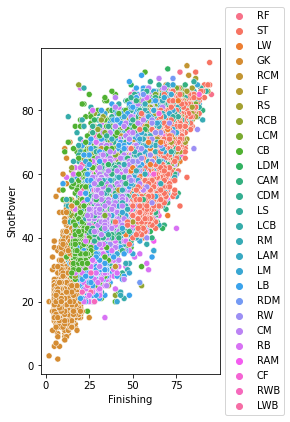

In [28]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.scatterplot(ax=ax, x="Finishing", y="ShotPower", hue="Position", data=df)
        
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Select columns of interest

In [29]:
df = df[["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Preferred Foot']]
df.dropna(subset=['Position'], inplace=True)
df

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,Left
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Right
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Right
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,Right
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,Right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,CM,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,Right
18203,ST,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,Right
18204,ST,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,Right
18205,RW,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,Right


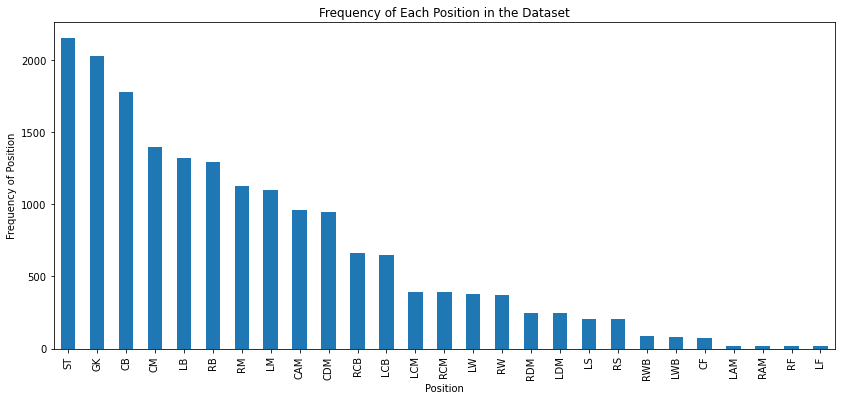

In [37]:
df_position_count = df["Position"].value_counts()
df_position_count.plot(kind = "bar", title = "Frequency of Each Position in the Dataset", xlabel = "Position", ylabel = "Frequency of Position", figsize=[14, 6])
plt.savefig(fname + 'position_bar_plot')

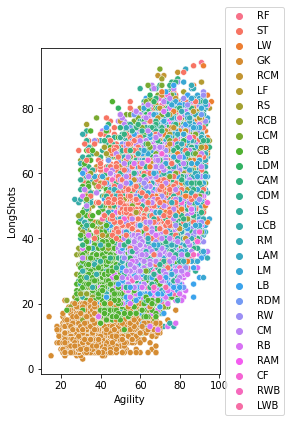

<Figure size 432x288 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.scatterplot(ax=ax, x="Agility", y="LongShots", hue="Position", data=df)
        
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
plt.savefig(fname + 'two_category_scatterplot')

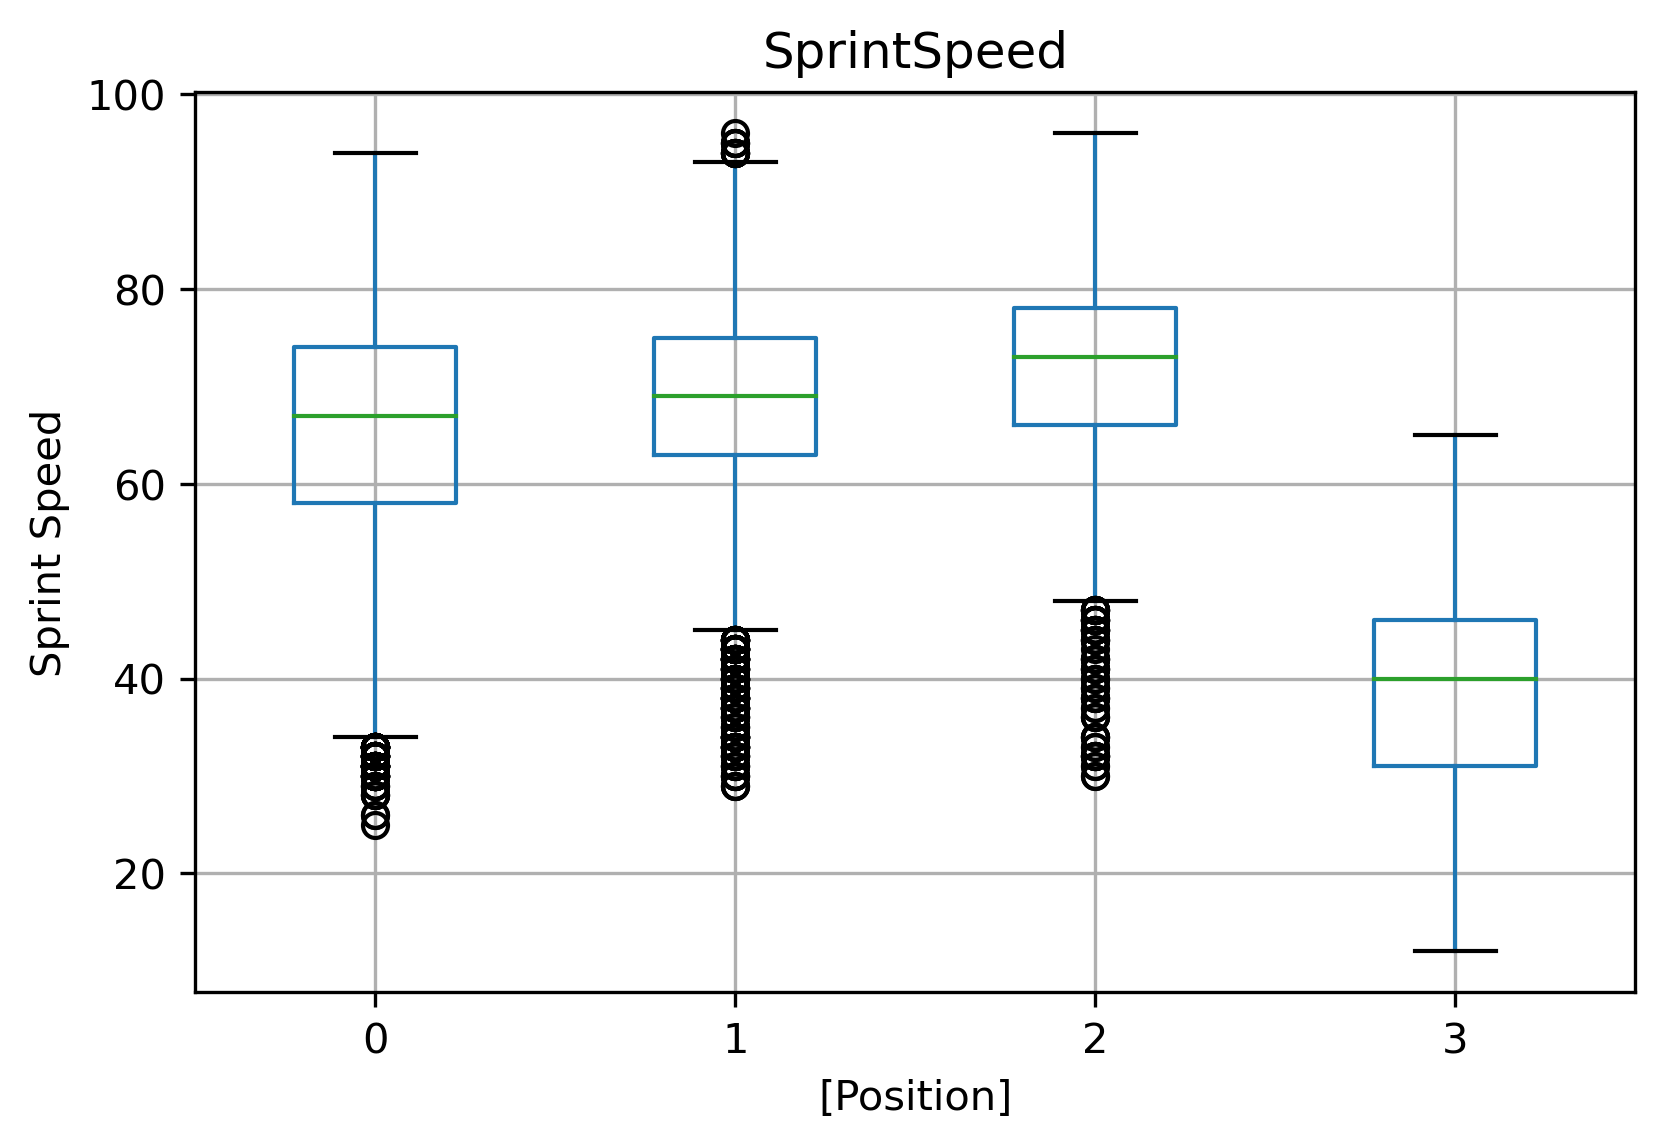

<Figure size 1800x1200 with 0 Axes>

In [46]:
df[['Position','SprintSpeed']].boxplot(by='Position') 
plt.ylabel('Sprint Speed')
plt.suptitle('')
plt.show()
plt.savefig(fname + 'box_plot')

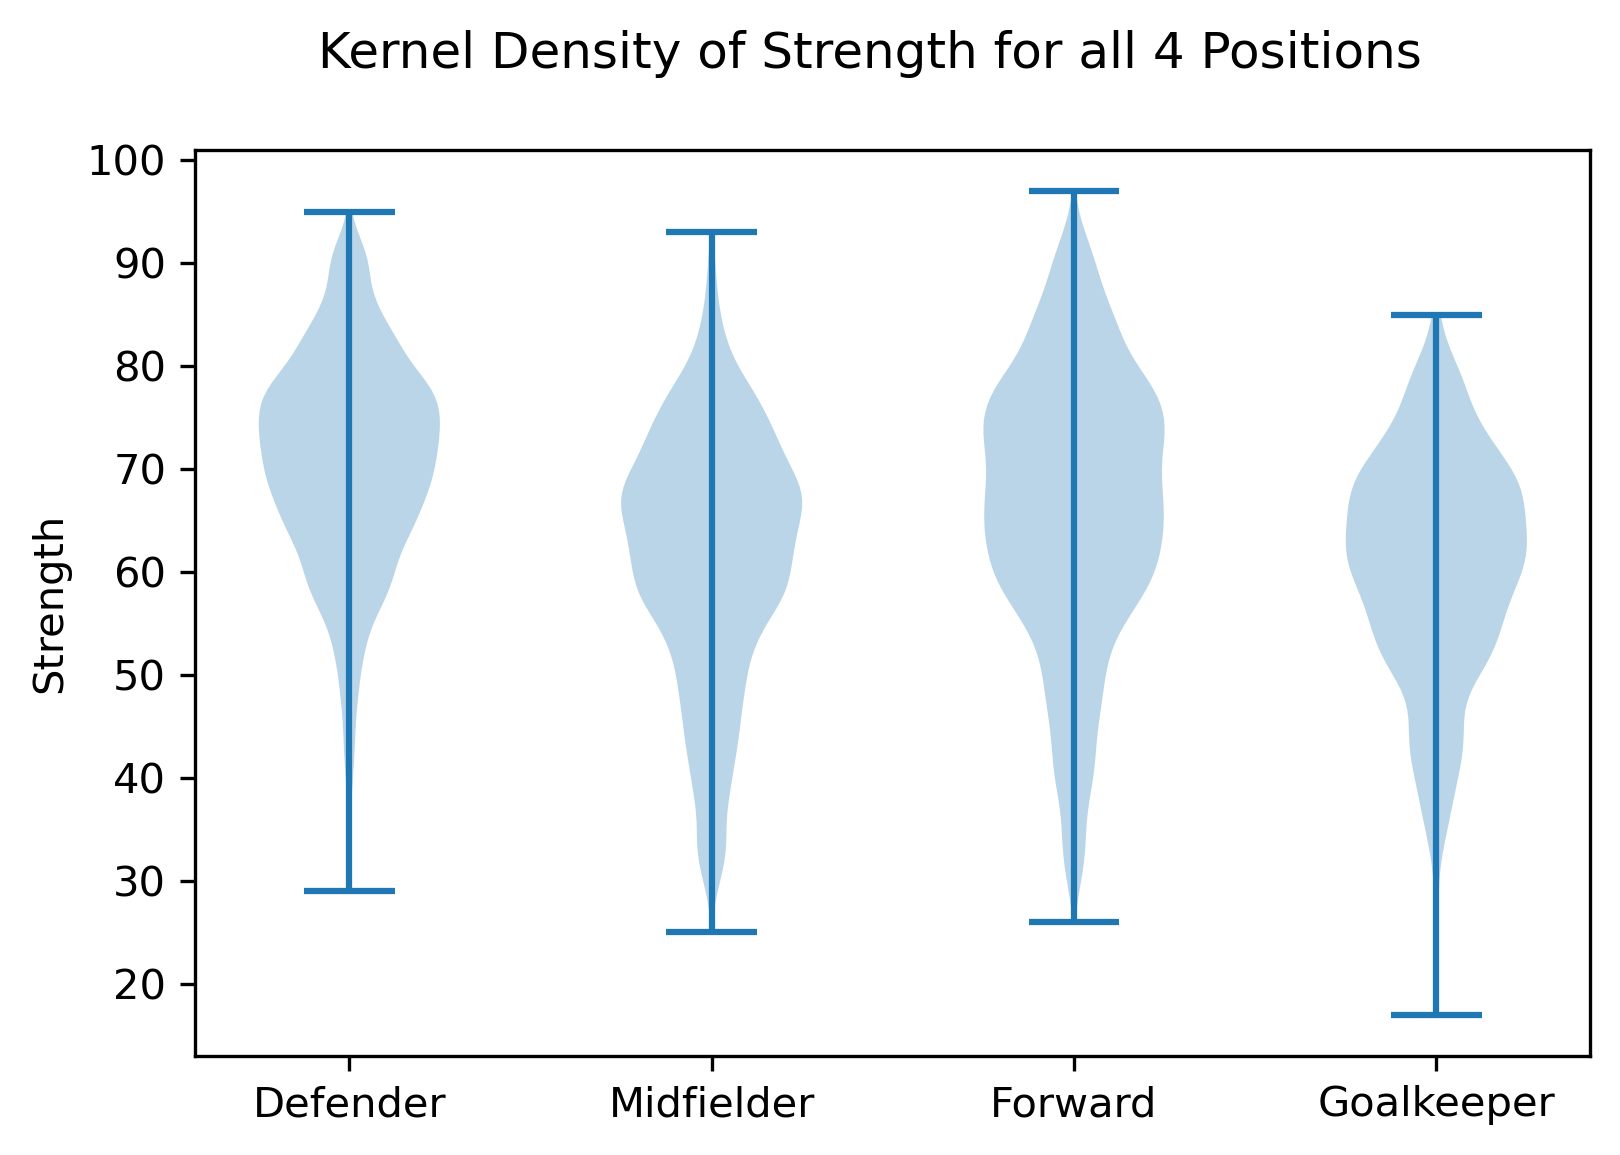

<Figure size 1800x1200 with 0 Axes>

In [45]:
dataset = [df[df['Position']== 0]['Strength'].values, df[df['Position']== 1]['Strength'].values, df[df['Position']== 2]['Strength'].values, df[df['Position']== 3]['Strength'].values]
plt.violinplot(dataset = dataset) 
plt.xticks([1,2,3,4],['Defender', 'Midfielder','Forward', 'Goalkeeper']) 
plt.ylabel('Strength')
plt.suptitle('Kernel Density of Strength for all 4 Positions')
plt.show()
plt.savefig(fname + 'violin_plot')

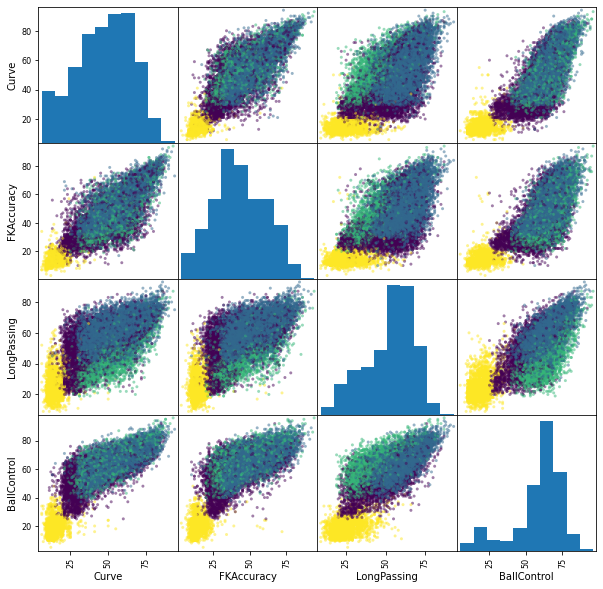

In [44]:
scatter_matrix_cols_df = df[['Curve', 'FKAccuracy', 'LongPassing', 'BallControl']]
scatter_matrix_cols_df

pd.plotting.scatter_matrix(scatter_matrix_cols_df, figsize = (10, 10), c = df["Position"])
plt.rcParams["figure.dpi"] = 300
plt.savefig(fname + 'scatter_matrix_plot.png')

In [39]:
forward = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]
goalkeeper = ["GK"]

In [40]:
df.loc[df["Position"].isin(defender), "Position"] = 0
df.loc[df["Position"].isin(midfielder), "Position"] = 1
df.loc[df["Position"].isin(forward), "Position"] = 2
df.loc[df["Position"].isin(goalkeeper), "Position"] = 3

In [41]:
count_numerical_values = len(df.select_dtypes(include = numerical_values).columns)
count_categorical_values = len(df.select_dtypes(include = categorical_values).columns)

print("Number of Numerical Features: ", count_numerical_values)
print("Number of Categorical Features: ", count_categorical_values)

Number of Numerical Features:  33
Number of Categorical Features:  2


In [51]:
def basic_split(X, y, train_size, val_size, test_size, random_seed):
    input_sum = train_size + val_size + test_size
    
    #Test the inputs:
    if (input_sum != 1):
        raise ValueError("The sum of train_size, val_size, and test_size must equal to 1, Try again!")
        
    if not isinstance(random_seed, int):
        raise ValueError("random_seed must be an integer!")
        
    if len(X.shape) != 2:
        raise ValueError("Input Parameter X must be a 2d Pandas Data Frame")
        
    if X.shape[0] != len(y):
        raise ValueError("The number of rows in input parameter X should be equal to the length of input parameter y")
        
    #Use train_test_split to split the training test:
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = train_size, random_state = random_seed)
    
    #Use train_test_split to split the testing/validation test:
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, y_rem, train_size = (val_size/(val_size + test_size))
                                                        , random_state = random_seed)
    
    train_shape = X.shape[0] * train_size - X_train.shape[0]
    valid_shape = X.shape[0] * val_size - X_valid.shape[0]
    test_shape = X.shape[0] * test_size - X_test.shape[0]
    
    #Test the outputs:
    if abs(train_shape) > 1 and abs(valid_shape) > 1 and abs(test_shape):
        raise Exception("The output sizes for train, validation, and test are incorrect, please try again!")
        
    return X_train, y_train, X_valid, Y_valid, X_test, Y_test

In [52]:
X_train_df, y_train_df, X_valid_df, y_valid_df, X_test_df, y_test_df = basic_split(df.loc[:, df.columns != "Position"], 
                                                                                   df["Position"], 0.6, 0.2, 0.2, 
                                                                                   random_seed = 5)

In [53]:
print(X_train_df.shape)
print(X_valid_df.shape)
print(X_test_df.shape)

(10888, 34)
(3629, 34)
(3630, 34)


In [54]:
print(X_train_df.head())
print(X_valid_df.head())
print(X_test_df.head())

       Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  \
13031       54.0             56.0          59.0     62.0       66.0   58.0   
13213       63.0             56.0          52.0     66.0       61.0   49.0   
6182        43.0             58.0          66.0     45.0       69.0   65.0   
5280        59.0             57.0          74.0     52.0       73.0   72.0   
3987        60.0             47.0          66.0     49.0       73.0   58.0   

       FKAccuracy  LongPassing  BallControl  Acceleration  ...  Composure  \
13031        45.0         46.0         63.0          73.0  ...       57.0   
13213        34.0         50.0         60.0          89.0  ...       55.0   
6182         48.0         59.0         70.0          75.0  ...       63.0   
5280         63.0         72.0         72.0          71.0  ...       70.0   
3987         36.0         57.0         69.0          91.0  ...       58.0   

       Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling 

In [56]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

OneHotEncoder_ftrs = ["Preferred Foot"]

MinMaxScaler_ftrs = ['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
                                                                                      
OneHotEncoder_enc = OneHotEncoder(sparse = False, handle_unknown = "ignore")
MinMaxScaler_enc = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder_enc, OneHotEncoder_ftrs), 
        ('minmax', MinMaxScaler_enc, MinMaxScaler_ftrs)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train_df)
X_valid_prep = clf.transform(X_valid_df)
X_test_prep = clf.transform(X_test_df)

print(X_train_df.shape)
print(X_train_prep.shape)
print(X_train_prep)

(10888, 34)
(10888, 35)
[[1.         0.         0.55913978 ... 0.06666667 0.13483146 0.05376344]
 [0.         1.         0.65591398 ... 0.14444444 0.14606742 0.11827957]
 [0.         1.         0.44086022 ... 0.15555556 0.07865169 0.08602151]
 ...
 [0.         1.         0.27956989 ... 0.06666667 0.1011236  0.07526882]
 [0.         1.         0.50537634 ... 0.1        0.08988764 0.06451613]
 [1.         0.         0.49462366 ... 0.07777778 0.08988764 0.04301075]]
